# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
import pandas as pd

In [161]:
import matplotlib.pyplot as plt

In [10]:
import sentencepiece

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
import sys
sys.path.insert(1, '/kaggle/input/datasetpy')

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [6]:
import torch
import numpy as np
from dataset import TextDataset

In [8]:
import tqdm

In [11]:
train_set = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=False, sp_model_prefix='bpe')

In [12]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [13]:
from model import LanguageModel

In [14]:
model = LanguageModel(train_set)

In [15]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [21]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from torch import nn
import torch.optim as optim
from train import train
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [17]:
NUM_EPOCHS = 20

model = LanguageModel(train_set, rnn_type=nn.RNN).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = None
criterion = nn.CrossEntropyLoss()

sum(param.numel() for param in model.parameters())

1157584

In [19]:
pad_id = train_set.pad_id
pad_id

69

In [22]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


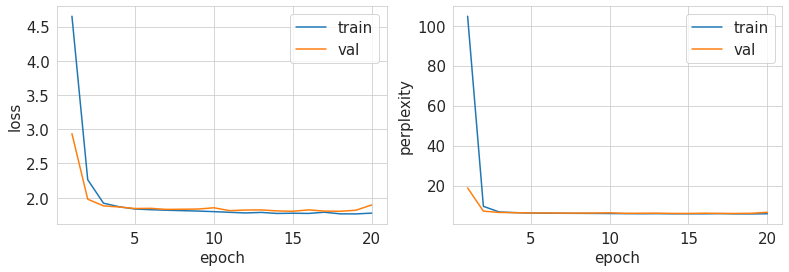

Generation examples:
обсужены ни один ее знает.
- хорошо редко оказывается, и живой, она разница привезли в тройке, в скамейке смешлось мыть посуду. он ожидающий обратно нашего правительства лучше в общественного-грева - он зверятеля поняла пора спать, которая продает официальное водку - это на лбук пошла?- это отчего получше лампочка ничем не окрайти!
- пап, сказала красивая проти летнейка?! как у вас нужно не догадала его в беррок?- так не придумал на два часа, твои ошибке?тот, а охотят всех жителя зима.
- милый, сорок твою миннелось.
показывая дуры и нашевших европейным женщина человека.


In [23]:
train(model, optimizer, scheduler, train_loader, val_loader, NUM_EPOCHS)

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [24]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
NUM_EPOCHS = 20

model_lstm = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm, T_max=20)
criterion = nn.CrossEntropyLoss()

sum(param.numel() for param in model_lstm.parameters())

1552336

In [25]:
model_lstm.rnn_type

torch.nn.modules.rnn.LSTM

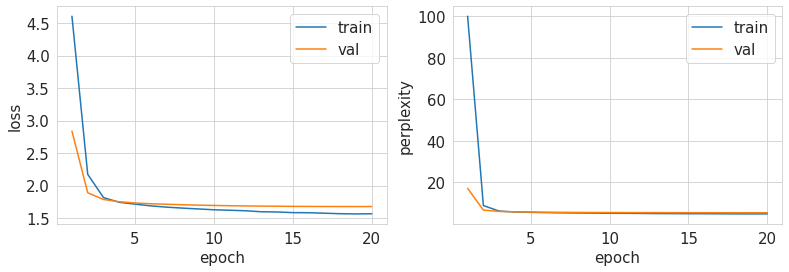

Generation examples:
объявление в зимнюю работу начал пытать почтонуть. они не такие чистая, получилось и нечем понять, что тогда снимаешь, а не из-защите!
гинеколог спрашивает у ухрюпинска компенкович предласенный больной груши узнал коза, не действует у них самый красивый отец, который в россии дополнительно.
- у вас чего нет дезодоранства с мозгом, попасть?! быстро, на улице!.
если согоды силы моет песни - спрашиваешь от папытов?
в общаются, разрешили нашей операции в мире янделетенской лестницы.сспс-ель, укажди ипотека.


In [26]:
train(model_lstm, optimizer_lstm, scheduler, train_loader, val_loader, NUM_EPOCHS)

лучше отрабатывает модель lstm


## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [27]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
temp = np.logspace(-6, 1, 10)
temp

array([1.00000000e-06, 5.99484250e-06, 3.59381366e-05, 2.15443469e-04,
       1.29154967e-03, 7.74263683e-03, 4.64158883e-02, 2.78255940e-01,
       1.66810054e+00, 1.00000000e+01])

In [28]:
for prefix in ['путин', 'медведь', 'зашли в бар', 'водка гусь школа']:
  for temp_sample in temp:
    generated = model_lstm.inference(prefix, temp=temp_sample)
    print('result=', generated, 'prefix=', prefix, 'temperature=', temp_sample)

result= путин заявил, что в россии все люди в россии не могут выбрать на работу. prefix= путин temperature= 1e-06
result= путин заявил, что в россии все люди в россии не могут выбрать на работу. prefix= путин temperature= 5.994842503189409e-06
result= путин заявил, что в россии все люди в россии не могут выбрать на работу. prefix= путин temperature= 3.5938136638046256e-05
result= путин заявил, что в россии все люди в россии не могут выбрать на работу. prefix= путин temperature= 0.00021544346900318845
result= путин заявил, что в россии все люди в россии не могут выбрать на работу. prefix= путин temperature= 0.001291549665014884
result= путин заявил, что в россии все люди в россии не могут выбрать на работу. prefix= путин temperature= 0.007742636826811269
result= путин заявил, что в россии появился новый вид, что в россии не хватает денег. prefix= путин temperature= 0.04641588833612782
result= путин в россии появился новый вид, что в россии все время отсутствуют, что они не могут выполни

можем сделать вывод, что чем больше значение temperature, тем хуже качество анекдотов + тем длиннее сам анекдот. также, смешнявость(ну или качество, как угодно) анекдота сильно зависит от популярности и простоты префикса. на простых префиксах генерится что-то более осмысленное и адекватное, когда как на несвязном префиксе - "водка гусь школа" сгенерировалось нечто скорее странное:)

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [74]:
rm /kaggle/working/unigram.model

In [75]:
train_set_1 = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=5000)
valid_set_1 = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=5000)

In [76]:
train_set_1.vocab_size

5000

In [79]:
NUM_EPOCHS = 20

model_lstm_5k = LanguageModel(train_set_1, rnn_type=nn.LSTM).to(device)
optimizer_lstm_5k = optim.Adam(model_lstm_5k.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm_5k, T_max=20)
criterion = nn.CrossEntropyLoss()

sum(param.numel() for param in model_lstm_5k.parameters())

3091336

In [80]:
train_loader_5k = DataLoader(train_set_1, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader_5k = DataLoader(valid_set_1, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


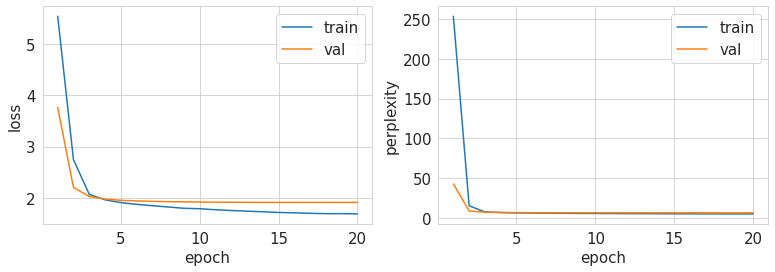

Generation examples:
быстро солнечный труп приносит водитель и обкури.
вам нужно было хотеть и ходить на лесное!потом передо мной дверь, развод - раз, похоже, дает 2 ⁇ 2 учебников! интересно, я же не виновата, но это дороже пова!
- вы знаете, в россии запретили бесплатного дома и говорить ребята, сейчас я обещаю тебе угнатью!- а что это за евровидение? осматриренный ротен, несмотря наступая за кофе, а за хипл взялись на дорожку?
изменила моя комин все сложножена до контрагестанты до 25 дополнника. интересно, что поспать?
- я буду похож на то, как ты думаешь и не знаешь, как твоя лень такая... кипятелит квану?


In [81]:
train(model_lstm_5k, optimizer_lstm_5k, scheduler, train_loader_5k, val_loader_5k, NUM_EPOCHS)

In [95]:
train_set_2 = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=7000)
valid_set_2 = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=7000)

In [96]:
train_set_2.vocab_size

7000

In [97]:
NUM_EPOCHS = 20

model_lstm_7k = LanguageModel(train_set_2, rnn_type=nn.LSTM).to(device)
optimizer_lstm_7k = optim.Adam(model_lstm_7k.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm_7k, T_max=20)
criterion = nn.CrossEntropyLoss()

sum(param.numel() for param in model_lstm_7k.parameters())

4117336

In [98]:
train_loader_7k = DataLoader(train_set_2, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader_7k = DataLoader(valid_set_2, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


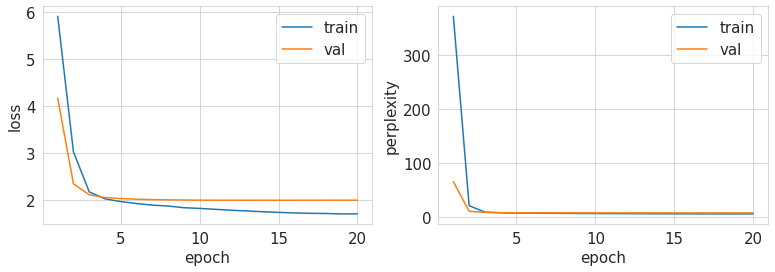

Generation examples:
изливательницы. так выскоренились... с немцами за руку дивана, девок не дура!
после смерти известные женщины в два метра сыграют 50 рублей для от сердца, с обычным возвращалом. .
ты перед отпуском ларькетов нельзя дважды. есть один недостаток последнего у другого!
- как ты подкалываешь?- не вырос! как все верблюды! радыхаешь... сайта смят! типа, отличие денег, умирают затуска?
летом как солдально поют люди, как живое лето...


In [99]:
train(model_lstm_7k, optimizer_lstm_7k, scheduler, train_loader_7k, val_loader_7k, NUM_EPOCHS)

In [100]:
for prefix in ['путин', 'минет', 'любовь', 'победа', 'война']:
  generated = model_lstm_7k.inference(prefix)
  print('result=', generated, 'prefix=', prefix)

result= путин скажет умеет посадить дерево, привычке все языки ненавидел - теперь узнают. prefix= путин
result= минет - это все эти женщины. и бухают, говорят капельку - с перфоратором. prefix= минет
result= любовь - это палача, на белорусском монахареньке найден мальчик, аптекарь в обго офис.- а я просто уверен, что их нельзя бить мужа... prefix= любовь
result= победа - вкручение. prefix= победа
result= война имеет один из нас по следующих импортный аналиссо европейской внешности на войну не натуральные отношениях, но этот бизнес был новым годом. prefix= война


In [105]:
train_set_3 = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=7000)
valid_set_3 = TextDataset(data_file='/kaggle/input/jokes-in-russian/jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=7000)

In [108]:
NUM_EPOCHS = 20

model_unigram_7k = LanguageModel(train_set_3, rnn_type=nn.LSTM).to(device)
optimizer_unigram_7k = optim.Adam(model_unigram_7k.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_unigram_7k, T_max=20)
criterion = nn.CrossEntropyLoss()

sum(param.numel() for param in model_unigram_7k.parameters())

4117336

In [109]:
train_loader_7k_u = DataLoader(train_set_3, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader_7k_u = DataLoader(valid_set_3, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

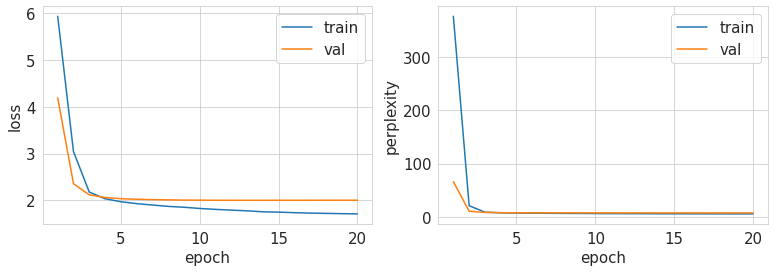

Generation examples:
деньги - это формулическое символе.
- сообщаю, что он к тебе сказал, какой у него только женщина. и в течете - между вежливым и ловей, картошки, тещи дерется матами княком!- так ты же сам не рыбу...
перелярии это киноаквучиками дедушкой и переседная.
- у меня вчера соседи по лгли, воспоминания ооленьгания на 10.- и что он там делаешь?- музыка далеко не осталось...
- почему ты обозвала, думаешь, что-то мне твоей больно сказать?- придуманная перестанье возвращаться нельзя.


In [110]:
train(model_unigram_7k, optimizer_unigram_7k, scheduler, train_loader_7k_u, val_loader_7k_u, NUM_EPOCHS)

In [111]:
for prefix in ['путин', 'минет', 'любовь', 'победа', 'война']:
  generated = model_unigram_7k.inference(prefix)
  print('result=', generated, 'prefix=', prefix)

result= путин заявил, что в россии два разного сорвался как распойловять всю вит минзму граждано - вывезли в масках и запущенные камни. prefix= путин
result= минет детям в переее. у нее спрашивают и что откажешь. prefix= минет
result= любовь - это когда муж дергает свой алкоголь перед зеркалом вратанной за рулем артни и из-за твоего переходами! prefix= любовь
result= победа когда приходишь, проиграввой, выписывание девушек и скалкуть по утрам. потому что если мир с группой спилась - это время... prefix= победа
result= война людей тоже снимет своей связи своих агрессивно. prefix= война


сравнивать эти модели по perplexity нельзя, потому что размеры словарей разные, и токенизаторы(токенайзеры) из-за этого тоже разные. вот здесь пруф https://towardsdatascience.com/perplexity-of-language-models-revisited-6b9b4cf46792

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [115]:
valid_dataset = valid_set.ids2text(valid_set.indices)

In [84]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
dataset_5k = []
for i in range(len(valid_set)):
  generated = model_lstm_5k.inference(prefix=' ')
  dataset_5k.append(generated)


In [101]:
dataset_7k = []
for i in range(len(valid_set)):
  generated = model_lstm_7k.inference(prefix=' ')
  dataset_7k.append(generated)

In [112]:
dataset_7k_u = []
for i in range(len(valid_set)):
  generated = model_unigram_7k.inference(prefix=' ')
  dataset_7k_u.append(generated)

считаем cosine similarity для модели bpe на 5000 токенов

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

corpus1 = valid_dataset + dataset_5k

vectorizer = TfidfVectorizer(min_df=2)
bag_of_words = vectorizer.fit_transform(corpus1)
vectorizer.get_feature_names_out()

svd = TruncatedSVD(n_components=100)
lsa = svd.fit_transform(bag_of_words)

knn = NearestNeighbors(n_neighbors=6039, metric='cosine')
knn.fit(lsa)

res_idx = knn.kneighbors(lsa[6038:], return_distance=False)


In [119]:
neighbours_idx = pd.DataFrame(res_idx)
neighbours_idx.drop(0, inplace=True, axis=1)

copy = neighbours_idx
copy = copy.applymap(lambda x: None if x >=6038 else x)



In [121]:
from numpy.linalg import norm

def cosine_similarity(A, B):
    if norm(A) == 0 or norm(B) == 0:
        return 0
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine

In [123]:
best_idx = copy.apply(lambda row: row.first_valid_index(), axis=1)
best_idx = pd.DataFrame(best_idx)
sum = 0
for index, row in best_idx.iterrows():
#     print(lsa[int(copy.iloc[index][row[0]])])
    vec1 = lsa[int(copy.iloc[index][row[0]])]
#     print(lsa[index + 6038])
    vec2 = lsa[index + 6038]
    sum += cosine_similarity(vec1, vec2)
    
sum /= len(valid_dataset)

делаем для модели размера 7к bpe

In [131]:
corpus2 = valid_dataset + dataset_7k

vectorizer2 = TfidfVectorizer(min_df=2)
bag_of_words2 = vectorizer2.fit_transform(corpus2)
vectorizer2.get_feature_names_out()

svd2 = TruncatedSVD(n_components=100)
lsa2 = svd.fit_transform(bag_of_words2)

knn = NearestNeighbors(n_neighbors=6039, metric='cosine')
knn.fit(lsa2)

res_idx2 = knn.kneighbors(lsa2[6038:], return_distance=False)


In [132]:
neighbours_idx2 = pd.DataFrame(res_idx2)
neighbours_idx2.drop(0, inplace=True, axis=1)

copy2 = neighbours_idx2
copy2 = copy2.applymap(lambda x: None if x >=6038 else x)

In [133]:
best_idx2 = copy2.apply(lambda row: row.first_valid_index(), axis=1)
best_idx2 = pd.DataFrame(best_idx2)
sum2 = 0
for index, row in best_idx2.iterrows():
#     print(lsa[int(copy.iloc[index][row[0]])])
    vec1 = lsa2[int(copy2.iloc[index][row[0]])]
#     print(lsa[index + 6038])
    vec2 = lsa2[index + 6038]
    sum2 += cosine_similarity(vec1, vec2)
    
sum2 /= len(valid_dataset)

делаем то же самое для 3 модели

In [141]:
corpus3 = valid_dataset + dataset_7k_u

vectorizer3 = TfidfVectorizer(min_df=2)
bag_of_words3 = vectorizer3.fit_transform(corpus3)
vectorizer3.get_feature_names_out()

svd3 = TruncatedSVD(n_components=100)
lsa3 = svd.fit_transform(bag_of_words3)

knn = NearestNeighbors(n_neighbors=6039, metric='cosine')
knn.fit(lsa3)

res_idx3 = knn.kneighbors(lsa3[6038:], return_distance=False)

In [142]:
neighbours_idx3 = pd.DataFrame(res_idx3)
neighbours_idx3.drop(0, inplace=True, axis=1)

copy3 = neighbours_idx3
copy3 = copy3.applymap(lambda x: None if x >=6038 else x)

In [143]:
best_idx3 = copy3.apply(lambda row: row.first_valid_index(), axis=1)
best_idx3 = pd.DataFrame(best_idx3)
sum3 = 0
for index, row in best_idx3.iterrows():
#     print(lsa[int(copy.iloc[index][row[0]])])
    vec1 = lsa3[int(copy3.iloc[index][row[0]])]
#     print(lsa[index + 6038])
    vec2 = lsa3[index + 6038]
    sum3 += cosine_similarity(vec1, vec2)
    
sum3 /= len(valid_dataset)

In [145]:
results = {'tokenizer': [5000, 7000, 7000], 'model': ['bpe', 'bpe', 'unigram'], 'similarity': [sum, sum2, sum3]}
results = pd.DataFrame(data=results)
results

,tokenizer,model,similarity
0,5000,bpe,0.729889
1,7000,bpe,0.731242
2,7000,unigram,0.726556


насчет pros and cons LSA:
1. Минусы:
* алгоритм не учитывает различные значения одного и того же слова
* занимает довольно много памяти, из-за этого дорого сравнивать большие документы

2. Плюсы:
* можно сравнивать похожесть текстов
* можно понять основной смысл текста с помощью векторной репрезентации
* меньше шума в данных
* можем убирать слова которые не влияют на контекст но часто попадаются

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [154]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.manifold import TSNE
Gen_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(lsa[6038:])
Gen_embedded.shape

(6038, 2)

In [155]:
Val_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(lsa[:6038])

In [158]:
gen_pd = pd.DataFrame(data=Gen_embedded, columns=['x', 'y'])
val_pd = pd.DataFrame(data=Val_embedded, columns=['x', 'y'])

,x,y
0,40.032936,-35.706581
1,-52.328938,-46.724560
2,70.935158,-38.573391
3,-4.513467,42.953453
4,-1.354775,92.582619
...,...,...
6033,-5.400978,25.227964
6034,44.612469,5.302564
6035,18.213993,18.224905
6036,75.146118,43.154995


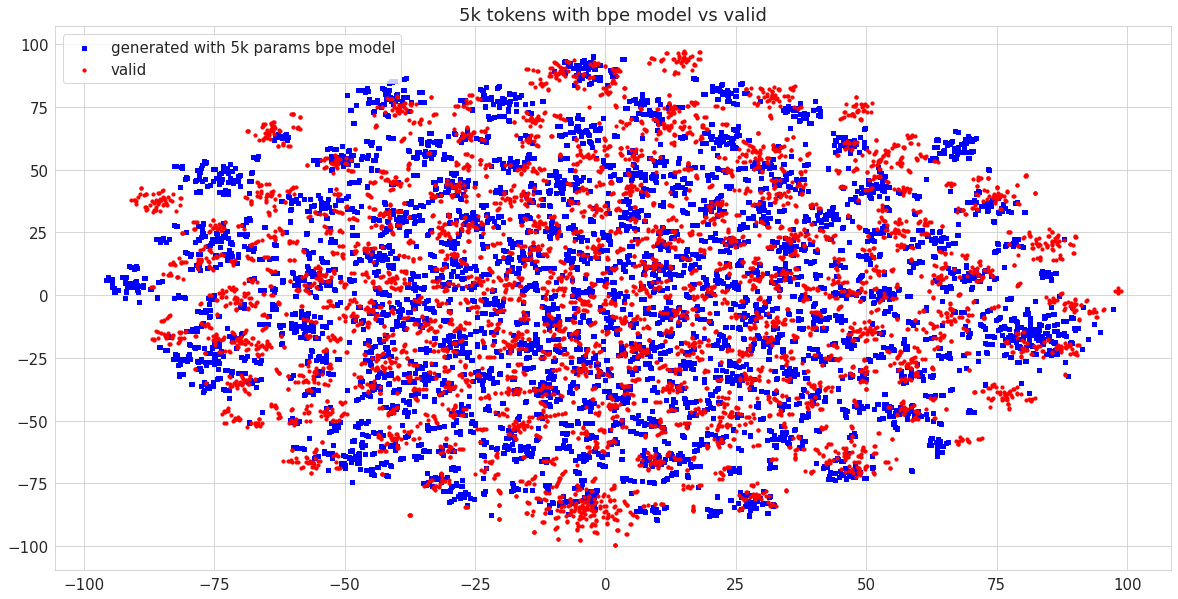

In [165]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(gen_pd['x'], gen_pd['y'], s=10, c='b', marker="s", label='generated with 5k params bpe model')
ax1.scatter(val_pd['x'], val_pd['y'], s=10, c='r', marker="o", label='valid')
plt.legend(loc='upper left')
plt.title('5k tokens with bpe model vs valid')
plt.show()

In [166]:
Gen_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(lsa2[6038:])

In [168]:
gen_pd2 = pd.DataFrame(data=Gen_embedded2, columns=['x', 'y'])

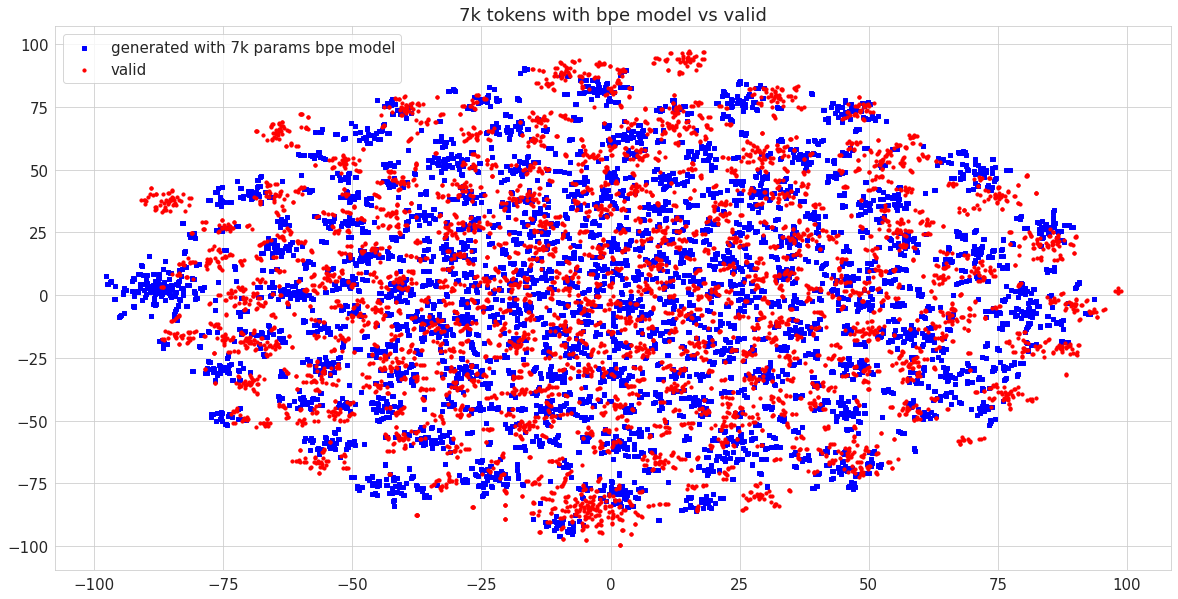

In [169]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(gen_pd2['x'], gen_pd2['y'], s=10, c='b', marker="s", label='generated with 7k params bpe model')
ax1.scatter(val_pd['x'], val_pd['y'], s=10, c='r', marker="o", label='valid')
plt.legend(loc='upper left')
plt.title('7k tokens with bpe model vs valid')
plt.show()

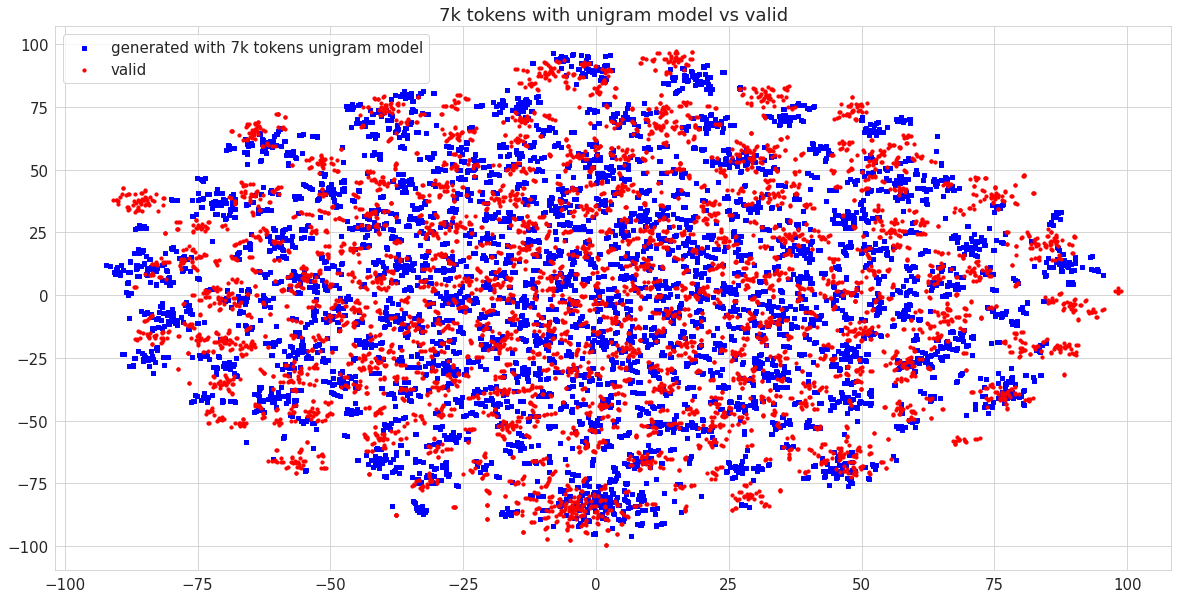

In [170]:
Gen_embedded3 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(lsa3[6038:])
gen_pd3 = pd.DataFrame(data=Gen_embedded3, columns=['x', 'y'])
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(gen_pd3['x'], gen_pd3['y'], s=10, c='b', marker="s", label='generated with 7k tokens unigram model')
ax1.scatter(val_pd['x'], val_pd['y'], s=10, c='r', marker="o", label='valid')
plt.legend(loc='upper left')
plt.title('7k tokens with unigram model vs valid')
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [172]:
from tqdm import tqdm

In [173]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)


Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [174]:
encodings = tokenizer("\n\n".join(dataset_5k), return_tensors="pt")

In [175]:
max_length = model.config.n_positions
stride = 50
seq_len = encodings.input_ids.size(1)
max_length

2048

In [190]:
#https://huggingface.co/docs/transformers/perplexity

def perplexity(model, encodings):
    max_length = model.config.n_positions
    stride = 500
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over input tokens.
            # Multiply it with trg_len to get the summation instead of average.
            # We will take average over all the tokens to get the true average
            # in the last step of this example.
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl1 = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl1

perlexity для датасета из 5к токенов bpe

In [186]:
print(perplexity(model, encodings))

tensor(389.6759, device='cuda:0')

In [187]:
encodings1 = tokenizer("\n\n".join(dataset_7k), return_tensors="pt")

perlexity для датасета из 7к токенов bpe

In [191]:
print(perplexity(model, encodings1))

 99%|█████████▊| 351/356 [00:53<00:00,  6.61it/s]


tensor(372.9427, device='cuda:0')


In [192]:
encodings2 = tokenizer("\n\n".join(dataset_7k_u), return_tensors="pt")

perlexity для датасета из 7к токенов unigram

In [193]:
print(perplexity(model, encodings2))

 99%|█████████▉| 355/359 [00:53<00:00,  6.61it/s]


tensor(371.6927, device='cuda:0')


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

я в опасности, потому что вот презервативы не ходят, а корову как везти?

недавно стал на всех жениться, потому что это мое семя мне уже предлагает. просто вот такой мир!

девушки такие: между нами будет будущее два раза -  ⁇ тогда надо 10 млн рублей.

- але, вы свободны с работы с женщинами?- да.- импортная?- ага!

путин приехал в кабинет к врачу и говорит- доктор, у меня есть парень.- а почему у вас в голове?- а я не знаю, что у меня есть.
